In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
#print(sys.path)

from parallel import Invoker

In [3]:
# Calculate params for simulations
from numpy import arange,linspace,logspace
NUM_SIMULATED_CORES = 16
F_STEP = 2
FunctionRange = arange(2,NUM_SIMULATED_CORES+F_STEP,F_STEP) # interval is open
#FunctionRange = [8]
GroupingRange = logspace(base=2,start=0,stop=4,num=5)

import math

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor
            
def filter_configs_by_cores(num_funcs,grouping,divisor_list):
    num_queues = num_funcs / grouping
    if num_queues in divisor_list:
        return True
        return (num_funcs,grouping,cores_per_q)
    
# Cores_per_q is always even for now by virtue of filter_configs_by_cores
def setup_final_config(num_funcs,grouping):
    num_queues = num_funcs / grouping
    cores_per_q = NUM_SIMULATED_CORES / num_queues
    return { 'funcs': int(num_funcs), 'grouping' : int(grouping), 'cores_per_q': int(cores_per_q)}
    
core_divisors = list(divisorGenerator(NUM_SIMULATED_CORES))
iterator_combinations = ((fr,gr) for fr in FunctionRange for gr in GroupingRange )
possible_combos = filter(lambda x : filter_configs_by_cores(x[0],x[1],core_divisors), iterator_combinations)
final_params = list(map(lambda x : setup_final_config(x[0],x[1]), possible_combos)) # don't run this cell repeatedly

In [12]:
#### Run simulations for various function numbers and various function grouping
def setup_sim(func_group,core_group,num_functions,load_range):
    invokerArgs = {'runnableTarg' : 'qmodel_dispatch',
                  'mode': 'sweep_A',
                  'numProcs' : 24,
                  'NumWorkers' : NUM_SIMULATED_CORES,
                   'argrange': load_range,
                   'NumFunctions': num_functions,
                   'FunctionGrouping': func_group,
                   'CoreGrouping': core_group,
                   'FixedTime' : 1500,
                   'WorkingSet' : 24*1024,
                   'RequestsToSimulate': 100000
                  }
    return invokerArgs

import pandas
# Return a pandas dataframe with all results
def run_sims(func_group,core_group,num_functions,load_range):
    args = setup_sim(func_group,core_group,num_functions,load_range)
    simulationController = Invoker( **args )
    print('Starting simulation for \(Nf,G\)',num_functions,core_group)
    simulationController.startProcs()
    simulationController.joinProcs()
    # Get results
    numProcs = args['numProcs']
    
    results = [ simulationController.getResultsFromQueue(idx) for idx in range(numProcs) ]
    flat_results = [ y for x in results for y in x ]
    
    # Remap results to the following format to import to pandas
    # { 'loads' : [ list of data points ]
    #    <Percentile Value> : [ list of data points ]
    # }
    def add_key_or_append(d,k,v):
        if k in d.keys():
            d[k].append(v)
        else:
            d[k] = []
            
    remap_dict = {}
    
    for x in flat_results:
        for load,times in x.items():
            load_mrps = 1/(load*1e-9)/1e6
            remap_dict[load_mrps] = times
    sorted_dict = {k:v for k,v in sorted(remap_dict.items(),key=lambda x : x[0])}
    f_dict = {}
    
    for load,time_dict in sorted_dict.items():
        # Append all loads to dict
        add_key_or_append(f_dict,'load',load)
        for p,v in time_dict.items():
            add_key_or_append(f_dict,str(p),v)      

    return args,pandas.DataFrame.from_dict(f_dict)

from numpy import linspace
### Run a group of simulations for each pair of num_functions/function_groupings
load_range = linspace(325,5000,50)
#args,ex_df = run_sims(4,4,16,load_range)
sims_gen = list(map(lambda x : run_sims(x['grouping'],x['cores_per_q'],x['funcs'],load_range),final_params))
;

Starting simulation for \(Nf,G\) 2 8
Simulation was unstable, last five service times from core 0 were: [103748.34147225833, 108022.4078241, 113982.43746143533, 112010.48375334335] , killing sim.
Simulation was unstable, last five service times from core 0 were: [105338.22739022059, 105952.26318468133, 112677.72472209082, 110754.69963117887] , killing sim.
Simulation was unstable, last five service times from core 0 were: [102660.41502611196, 109729.20162926629, 111081.28381940941, 114026.38569386839] , killing sim.
Simulation was unstable, last five service times from core 0 were: [102362.93014943408, 103699.6712524544, 112251.5547387122, 114686.72658217384] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec54320> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [105071.81494276099, 110788.24466060984, 120292.272833257, 126144.24171312507] , killing sim.
Simulation was unstable, las

Simulation was unstable, last five service times from core 0 were: [103073.0526056898, 112074.63183804392, 112346.67400590528, 121759.64218791708] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec3bcf8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101005.00332394891, 106512.90004261519, 108186.24827746506, 112708.17011798514] , killing sim.
Simulation was unstable, last five service times from core 0 were: [105964.18520828005, 113328.4911489308, 119039.03103101524, 121725.05660698298] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec220f0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101839.6145508978, 104406.78899560327, 113072.9132162878, 119194.87040670335] , killing sim.
Simulation was unstable, last five service times from core 0 were: [105350.46292797246, 108148.5

Simulation was unstable, last five service times from core 0 were: [109314.94435574522, 120883.34726749925, 123647.63571876062, 128538.9959647725] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec36908> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100044.60175696205, 113248.23896682008, 122310.8718595538, 126312.80257906043] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec36908> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100709.65528210228, 107924.10583398641, 119820.22099922474, 128605.86354302676] , killing sim.
Simulation was unstable, last five service times from core 0 were: [109418.94226372353, 118443.38605046028, 121680.56828391908, 131129.3457857995] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec5db38> has terminated and cannot be interrupt

Simulation was unstable, last five service times from core 0 were: [107720.99454860174, 114018.58919875216, 118734.09179366198, 125972.06505713315] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec227b8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [109354.0819018521, 120216.99274877166, 130779.21786123783, 137425.71910554255] , killing sim.
Simulation was unstable, last five service times from core 0 were: [105283.068136013, 114631.50369615528, 123514.00075236065, 129979.85800925326] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec28358> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [105537.20206670463, 106987.5219210425, 114129.8111011651, 121801.94582213156] , killing sim.
Simulation was unstable, last five service times from core 0 were: [103893.01582672942, 110315.12

Caught exception <Process(run) object at 0x7fcc4ec4fb70> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [107407.52989419924, 119517.28529997668, 129833.53800813758, 135097.6232274128] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec4fb70> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [109908.54565362442, 120928.81890317544, 122195.96133824722, 130738.84037458978] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec4fb70> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100951.93453160311, 106108.90320288265, 118073.72278573904, 114989.29079691114] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec4fb70> has terminated and cannot be interrupted. lets transparently ignore it


Simulation was unstable, last five service times from core 0 were: [108296.10872967113, 117805.62695505247, 128478.68593094614, 137914.84420328485] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec5d518> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [110778.8594437984, 124332.77701789589, 130351.3718779823, 143240.9727102667] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec5d518> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [109183.9981312993, 118833.85179765949, 130513.22481103813, 142763.07878690373] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec5d518> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [104861.8809941413, 114378.16944197254, 108516.92601273031, 1220

Caught exception <Process(run) object at 0x7fcc4ec331d0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100321.28218486143, 113465.87788349885, 125352.74425205716, 137851.11239289818] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec331d0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101304.77670463527, 112329.20036202407, 124842.11537842719, 135985.74469918024] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec331d0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [108943.35495022297, 119966.48747696955, 131725.69300899195, 142945.96965311505] , killing sim.
Caught exception <Process(run) object at 0x7fcc4ec331d0> has terminated and cannot be interrupted. lets transparently ignore it

Simulation was unstable, last five service times from core 0 were: [109719.85393151343, 116903.10908066091, 127645.82452491006, 138061.4499631006] , killing sim.
Caught exception <Process(run) object at 0x7fcc55ff6320> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100039.45967969473, 108545.0102288225, 117321.8796342348, 118985.88899671742] , killing sim.
Simulation was unstable, last five service times from core 0 were: [106937.36083305205, 113786.51581157782, 122857.72528814306, 128079.66406028159] , killing sim.
Caught exception <Process(run) object at 0x7fcc55c3fda0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [109275.87573912999, 117927.58504900621, 118995.14902456038, 119875.60265223004] , killing sim.
Caught exception <Process(run) object at 0x7fcc55c3fda0> has terminated and cannot be interrupt

''

Figure already exists with fname grouping_comparisons_2funcs_uniform.pdf will back up!
Figure already exists with fname grouping_comparisons_4funcs_uniform.pdf will back up!
Figure already exists with fname grouping_comparisons_8funcs_uniform.pdf will back up!
Figure already exists with fname grouping_comparisons_16funcs_uniform.pdf will back up!


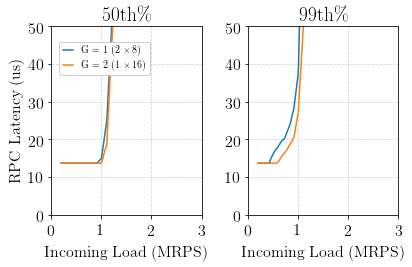

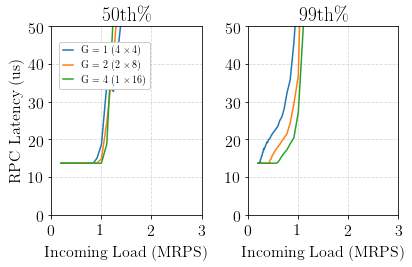

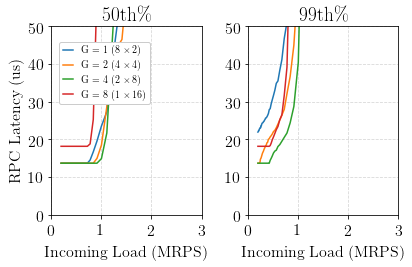

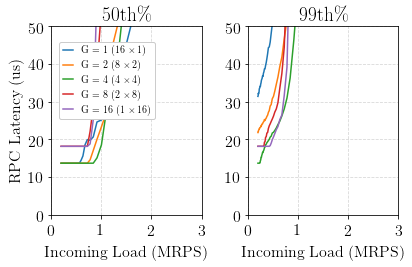

In [13]:
####### Create 50th and 99th% plots for various G
graph_us = {}
def init_or_add_val(d,k,k2,v):
    if k not in d.keys():
        d[k] = {}
    if k2 not in d[k].keys():
        d[k][k2] = v
    else:
        print('WARN: WOULD HAVE OVERWRITTEN DATA')

for args,df in sims_gen:
    tup_to_k2 = (args['FunctionGrouping'],args['CoreGrouping'])
    init_or_add_val(graph_us,args['NumFunctions'],tup_to_k2,df)
    
# Generate plots
import matplotlib.pyplot as plt
import numpy
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
fontdir = {'size':16,'family':'serif'}
rc('font',**fontdir)
rc('text',usetex=True)

for nfuncs,data in graph_us.items():
    fname = 'grouping_comparisons_'+str(nfuncs)+'funcs_uniform.pdf'
    if os.path.exists(fname):
        print('Figure already exists with fname',fname,'will back up!')
        fname_bak = fname + '.bak'
        os.rename(fname,fname_bak)

    with PdfPages(fname) as pp:
        f,axarr = plt.subplots(1,2)
        for tup, values in data.items():
            grouping = tup[0]
            cores_per_q = tup[1]
            num_queues = int(nfuncs / grouping)
            mathstring = r" $("+str(num_queues)+"\\times"+str(cores_per_q)+")$"
            l = 'G = ' + str(grouping) + mathstring
            values.plot(x='load',y='50',ax=axarr[0],label=l)
            values.plot(x='load',y='99',ax=axarr[1],label=l)

        for i,ax in enumerate(axarr):
            ax.grid(True,axis='both',linestyle='--',alpha=0.5)
            ax.get_legend().remove()


        handles, labels = axarr[0].get_legend_handles_labels()


        axarr[0].set_ylabel('RPC Latency (us)')
        axarr[0].set_xlabel('Incoming Load (MRPS)')
        axarr[1].set_xlabel('Incoming Load (MRPS)')
        axarr[0].set_ylim(0,50)
        axarr[1].set_ylim(0,50)
        axarr[0].set_xlim(0,3)
        axarr[1].set_xlim(0,3)
        axarr[0].set_xticks(numpy.linspace(0,3,4))
        axarr[1].set_xticks(numpy.linspace(0,3,4))
        axarr[0].set_title('50th\%')
        axarr[1].set_title('99th\%')

        f.legend(handles,labels,loc='upper left',bbox_to_anchor=(0.125,0.8),ncol=1,fontsize=10,frameon=True,framealpha=1,
            handlelength=1,columnspacing=1)

        f.tight_layout()
        pp.savefig()